# Formula 1 Modelling Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score ,mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
import joblib
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_complete_301022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
raceids=[989, 1010, 990, 1036, 1041, 1084, 1061, 1026, 1073, 1088]
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df,test_raceids=raceids)
ypos_train=y_train['quali_position'].copy()
ypos_test=y_test['quali_position'].copy()
ydelta_train=abs(y_train['lap_timedelta_milliseconds'].copy())
ydelta_test=abs(y_test['lap_timedelta_milliseconds'].copy())


In [40]:
Results_summary=[]

## Manual Feature Selection

In [4]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_results.pkl')
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.8].index)
features_remove =[ 'numerical_transform__fastestlap_Sector1',
 'numerical_transform__fastestlap_Sector2',
 'numerical_transform__fastestlap_Sector3', 
 ] 
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [5]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
linear_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('linear_regression',LinearRegression())# classifier
        
]
linear_pipe=Pipeline(linear_estimator)

In [6]:
linear_pos= linear_pipe.fit(X_train_manual,ypos_train)
pos_predictions=linear_pos.predict(X_test_manual)
print(f'Position Linear regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

linear_delta= linear_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=linear_delta.predict(X_test_manual)
print(f'Lap Delta Linear regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')



Position Linear regression Initial R2 score with manual selected featuers 0.4686308011801288
Position Linear regression Initial MAE score with manual selected feaure 2.9908472177933674
Lap Delta Linear regression Initial R2 score with manual selected featuers -0.26117657260662064
Lap Delta Linear regression Initial MAE score with manual selected feaure 898.9311224489796


In [14]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions

In [33]:
def homoscedasticity_test(residuals,predictions,**kwargs):

    fig, ax = plt.subplots(1, 2, figsize=(10,5),**kwargs)

    
    
    sm.ProbPlot(residuals).qqplot(line='s',ax=ax[0])
    ax[0].set_title('Q-Q plot of residuals')

    
    ax[1].plot(predictions,residuals,marker='o',linestyle = 'None')
    ax[1].set_title('Plot of residuals against predictions')
    ax[1].set_ylabel('Residuals')
    ax[1].set_xlabel('Predictions')
    plt.show()
    
    print("Shaprio-Wilk test of Residuals is: \n ", stats.shapiro(residuals))

    if float(stats.shapiro(residuals)[1]) < 0.05:
        print("can reject null hypothesis and residuals may not be normally distributed")
    else:
        print("can not reject null hypothesis and the residuals are likely normally distributed")
    print("---------------------------")
    


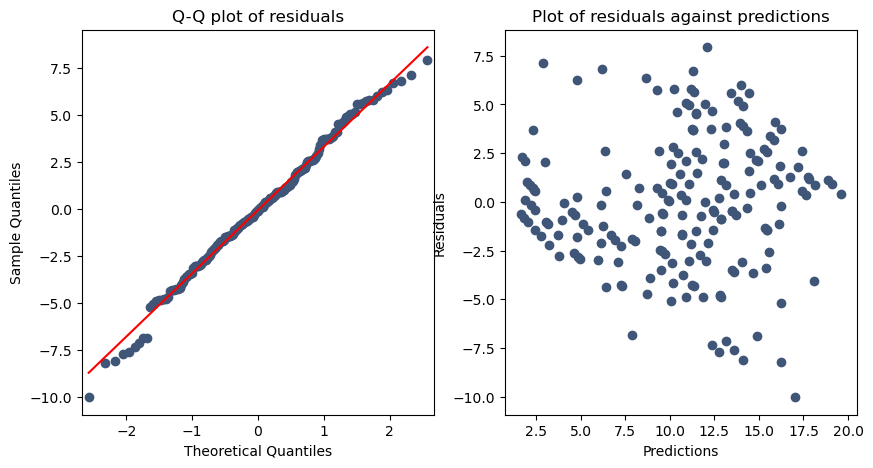

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9929277896881104, pvalue=0.4670012593269348)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


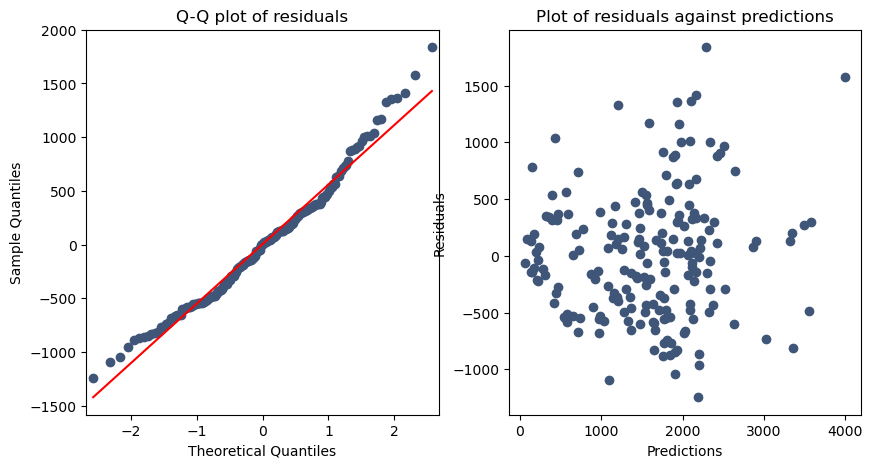

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9786797761917114, pvalue=0.004407133441418409)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [38]:
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

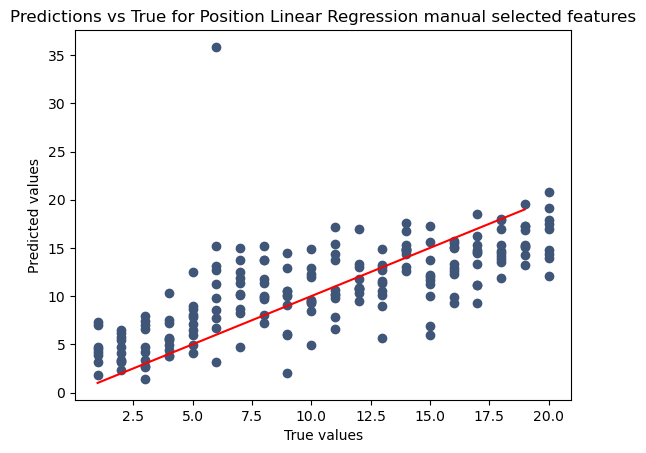

In [7]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Linear Regression manual selected features')
plt.show()

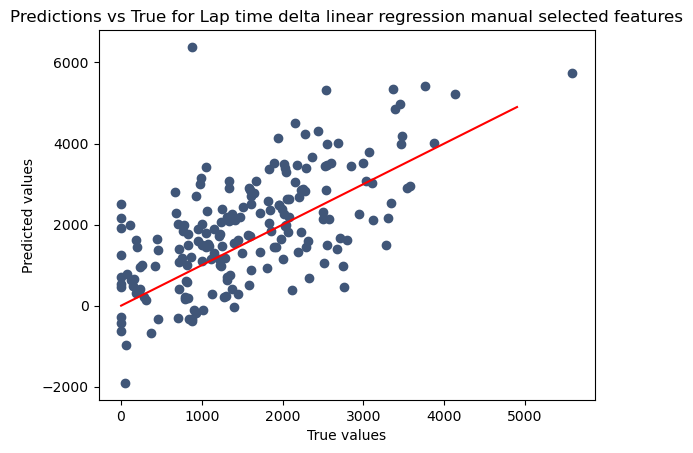

In [8]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta linear regression manual selected features')
plt.show()

In [41]:
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

## Random Forest Regression

In [47]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [48]:
forest_pos= forest_pipe.fit(X_train_manual,ypos_train)
pos_predictions=forest_pos.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=forest_delta.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6544647434699569
Position Random Forest regression Initial MAE score with manual selected feaure 2.6456632653061223
Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6890606956197174
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.31295918367346


In [152]:
joblib.dump(forest_delta,'./pickled_random_forest_initial_lapelta_model.pkl')
joblib.dump(forest_pos,'./pickled_random_forest_initial_position_model.pkl')

['./pickled_random_forest_initial_position_model.pkl']

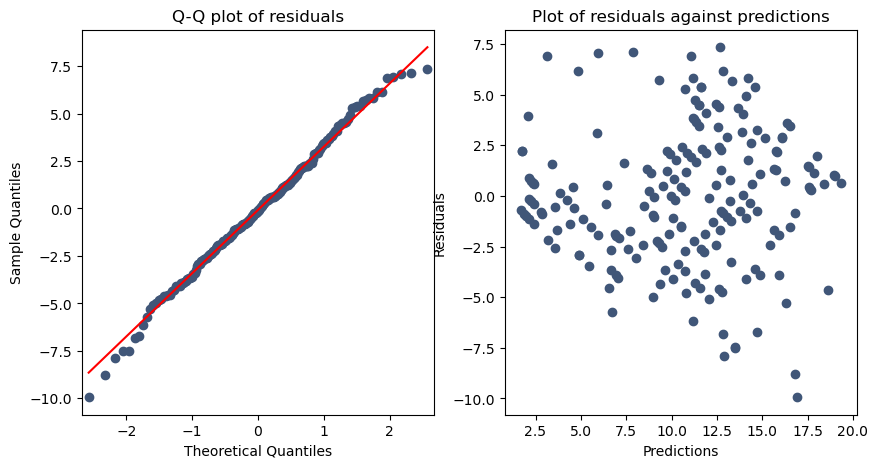

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9941951632499695, pvalue=0.6447181701660156)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


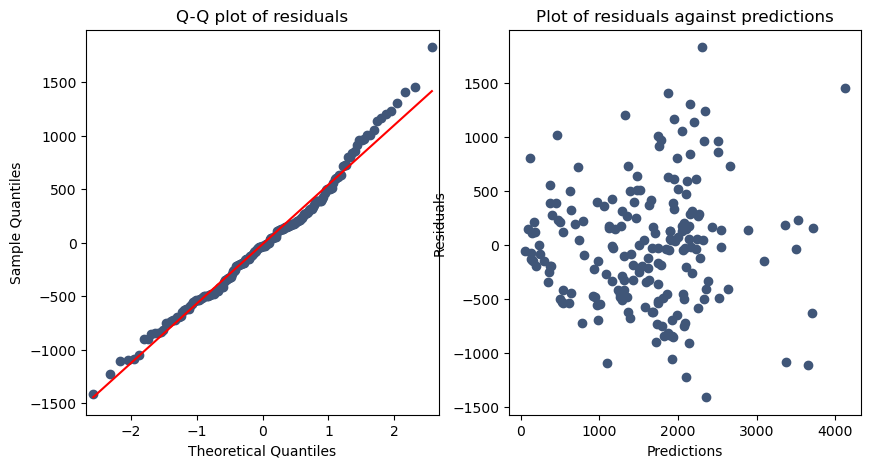

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9863252639770508, pvalue=0.054977815598249435)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [49]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

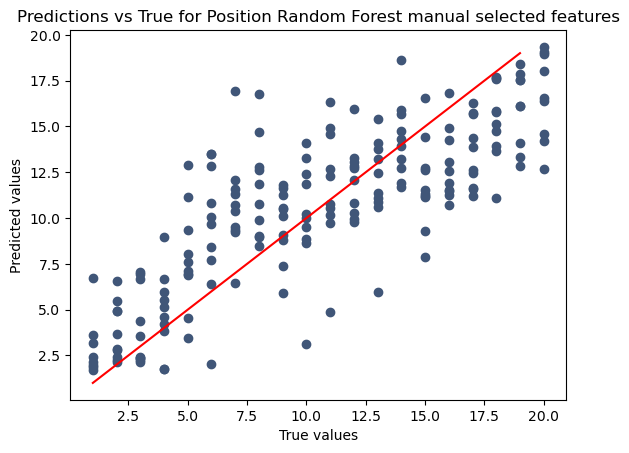

In [50]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest manual selected features')
plt.show()

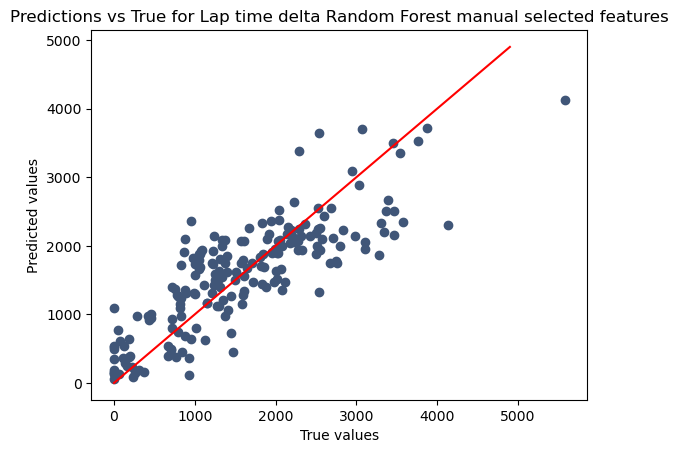

In [51]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest manual selected features')
plt.show()

In [52]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'yes'},index=[0]))

## Automatic Select Features 

In [53]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('select_from_model',SelectFromModel(RandomForestRegressor(),threshold=-np.inf,max_features=70)),
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [54]:
forest_pos= forest_pipe.fit(X_train,ypos_train)
pos_predictions=forest_pos.predict(X_test)
print(f'Position Random Forest regression Initial R2 score with auto selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train,ydelta_train)
delta_predictions=forest_delta.predict(X_test)
print(f'Lap Delta Random Forest regression Initial R2 score with auto selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with auto selected featuers 0.6496559715443899
Position Random Forest regression Initial MAE score with auto selected feaure 2.6768367346938775
Lap Delta Random Forest regression Initial R2 score with auto selected featuers 0.6813218350377463
Lap Delta Random Forest regression Initial MAE score with auto selected feaure 441.06704081632654


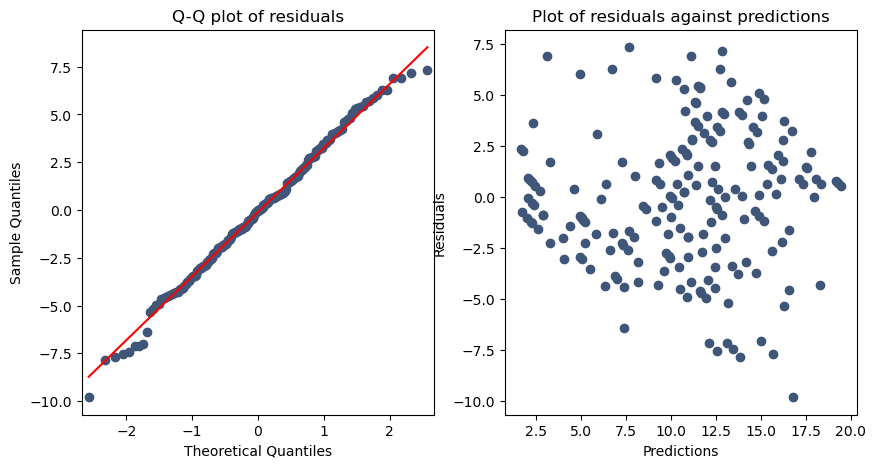

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9936692118644714, pvalue=0.5681770443916321)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


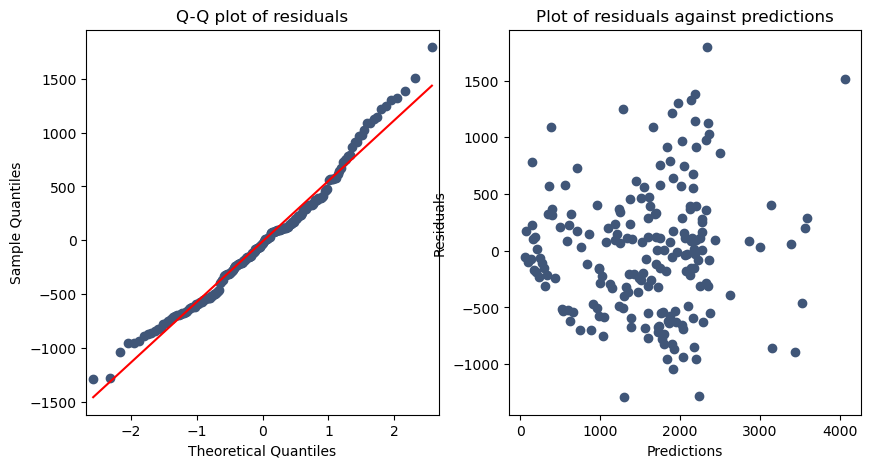

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9806280732154846, pvalue=0.008222158998250961)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [55]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

In [56]:
forest_pos['random_forest'].feature_importances_.shape

(70,)

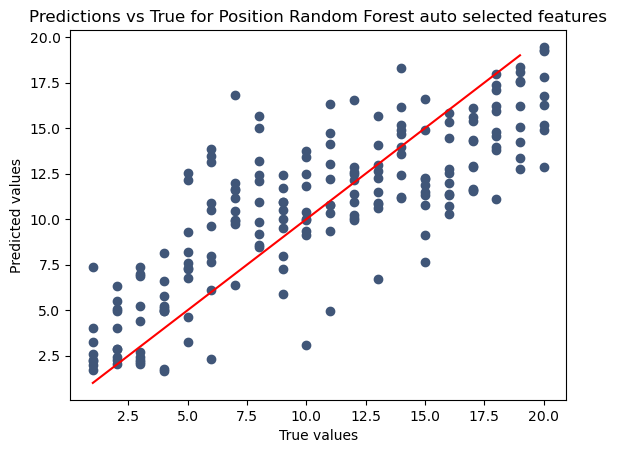

In [57]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest auto selected features')
plt.show()

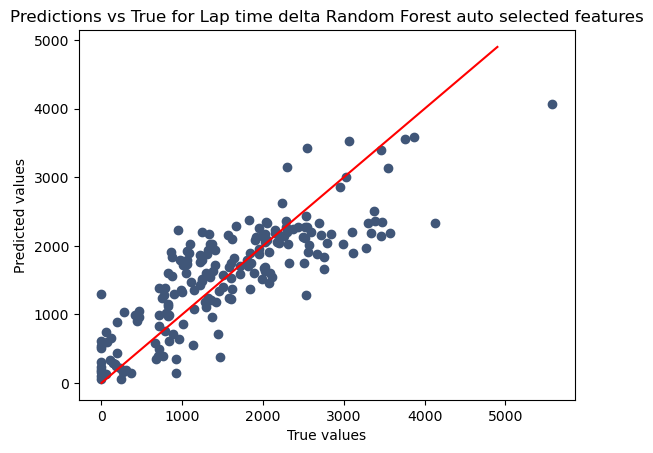

In [58]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest auto selected features')
plt.show()

In [59]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))

Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

## Optimise Lap time delta values manual features

In [110]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [111]:
forest_pipe['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [112]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(10,60,10)
   
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 380, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 20, 'random_forest__max_depth': 75, 'random_forest__criterion': 'poisson'}


In [113]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['poisson'],
    'random_forest__max_depth':np.arange(60,90,5),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(10,30,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'random_forest__criterion': 'poisson', 'random_forest__max_depth': 85, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 380}


In [114]:
print(fittedgrid_rf.best_params_)

{'random_forest__criterion': 'poisson', 'random_forest__max_depth': 85, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 380}


In [115]:
results_rf_pos = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_pos

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.452572,0.949167,350,60,10,1
1,0.474527,0.954430,360,60,10,1
2,0.489542,0.948855,370,60,10,1
3,0.498000,0.951501,380,60,10,1
4,0.488108,0.950908,390,60,10,1
...,...,...,...,...,...,...
115,0.478284,0.949646,350,85,25,1
116,0.466982,0.950326,360,85,25,1
117,0.492104,0.949296,370,85,25,1
118,0.472792,0.951978,380,85,25,1


In [116]:
print('Best Random Forest lap delta regression model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ydelta_test))

Best Random Forest lap delta regression model accuracy_score on X test: 0.69600260207725


In [117]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_lapdelta.pkl')

['pickled_best_RF_regression_model_lapdelta.pkl']

In [118]:
RF_best_lapdelta_model = joblib.load('pickled_best_RF_regression_model_lapdelta.pkl')

In [119]:
delta_predictions=RF_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.69600260207725
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 302845.31206437247
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.69212082399224


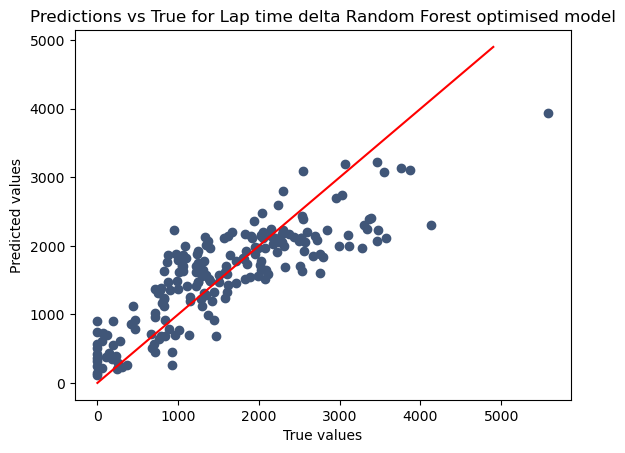

In [120]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest optimised model')
plt.show()

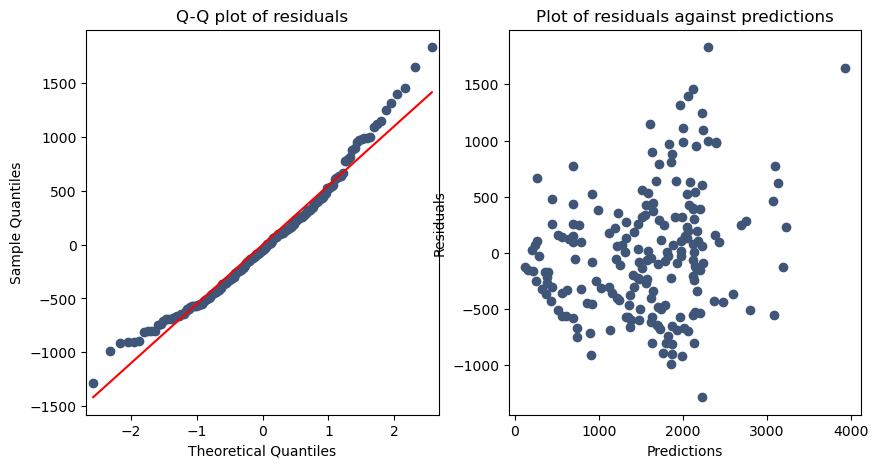

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9734931588172913, pvalue=0.0009052924579009414)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [121]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [122]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [123]:
print(f'Number of features used in the model {len(fittedgrid_rf.best_estimator_[:-1].get_feature_names_out())}')

Number of features used in the model 72


In [124]:
RF_results = pd.DataFrame(data=fittedgrid_rf.best_estimator_['random_forest'].feature_importances_ ,index=fittedgrid_rf.best_estimator_['column_transform'].get_feature_names_out())

In [125]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [126]:
RF_results

,Random_forest_result
numerical_transform__circuit_total_corner_curvature,0.014891
numerical_transform__circuit_mean_corner_curvature,0.016527
numerical_transform__max_max_speed,0.018491
numerical_transform__mean_straight_speed,0.030983
numerical_transform__var_straight_speed,0.026520
...,...
hot_encode__constructorRef_red_bull,0.025231
hot_encode__constructorRef_renault,0.000303
hot_encode__constructorRef_sauber,0.000795
hot_encode__constructorRef_toro_rosso,0.001234


<AxesSubplot: >

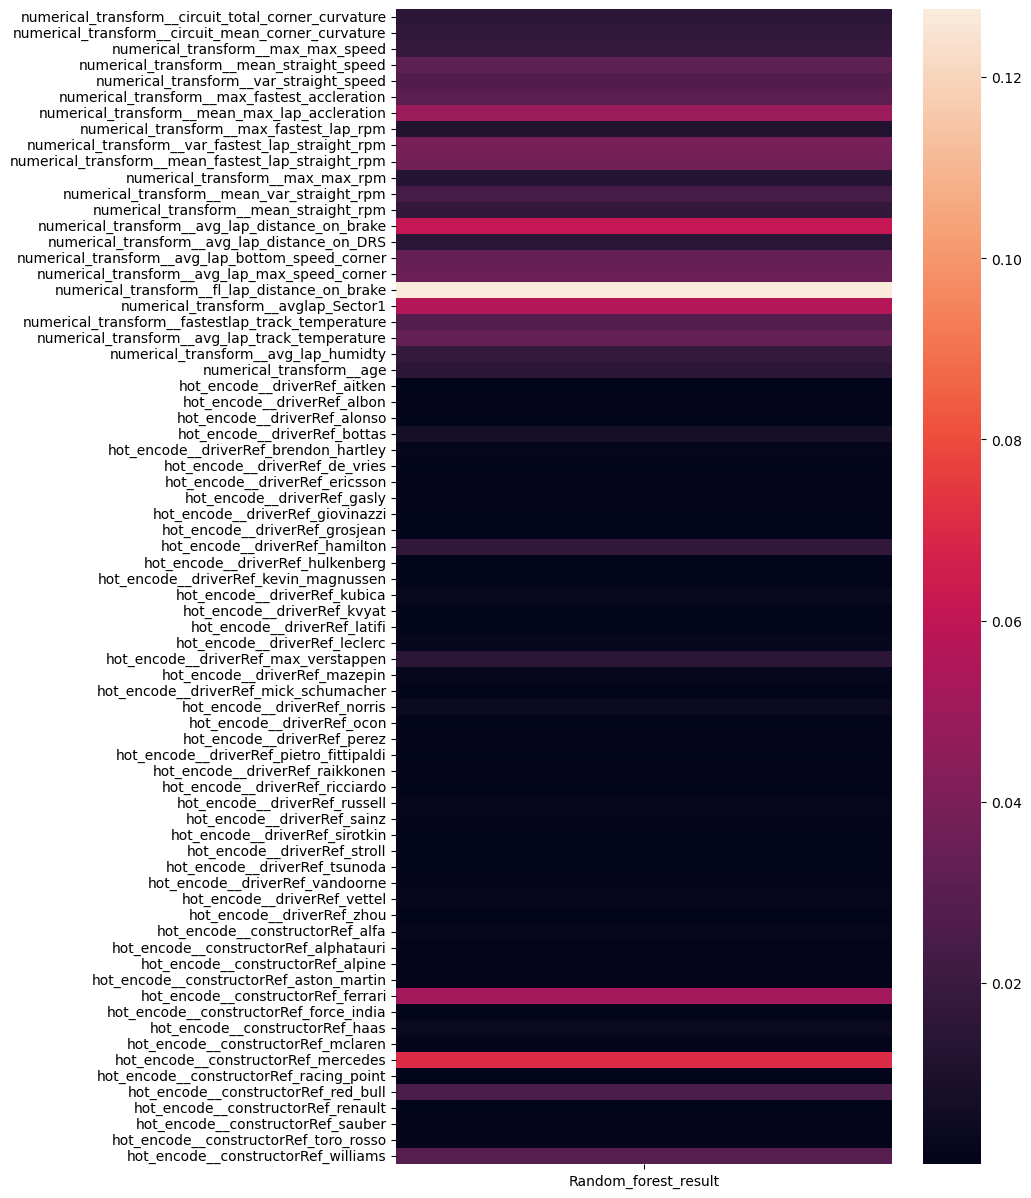

In [127]:
plt.figure(figsize=(8,15))
sns.heatmap(RF_results)

# Random Forest Optimise Qualifying Position

In [128]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,100,5),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(1,70,10),      
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 90, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 21, 'random_forest__max_depth': 45, 'random_forest__criterion': 'squared_error'}


In [129]:
print(fittedgrid_rf.best_params_)

{'random_forest__n_estimators': 90, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 21, 'random_forest__max_depth': 45, 'random_forest__criterion': 'squared_error'}


In [136]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(80,101,10),
    'random_forest__criterion':['squared_error'],
    'random_forest__max_depth':np.arange(35,51,5),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(15,31,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'random_forest__criterion': 'squared_error', 'random_forest__max_depth': 45, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 90}


In [137]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_position.pkl')

['pickled_best_RF_regression_model_position.pkl']

In [138]:
RF_best_pos_model = joblib.load('pickled_best_RF_regression_model_position.pkl')

In [139]:
pos_predictions=RF_best_pos_model.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6544225937178315
Position Random Forest regression Initial MSE score with manual selected feaure 11.12017825648778
Position Random Forest regression Initial MAE score with manual selected feaure 2.6789682539682538


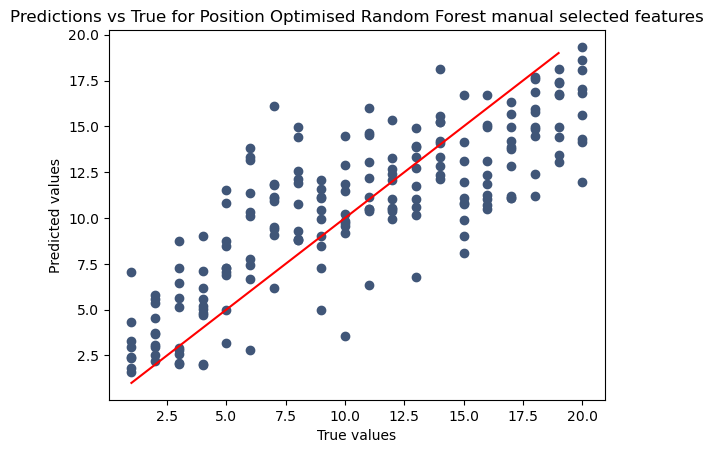

In [140]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Random Forest manual selected features')
plt.show()

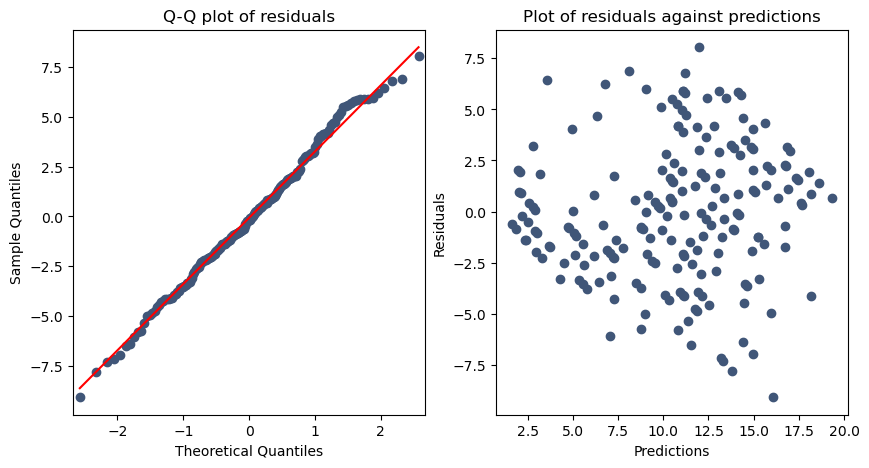

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9936732649803162, pvalue=0.5687599182128906)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [141]:
#residuals
pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)



In [142]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))


## XGBoost Regressor

In [130]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

xgboost_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('xgboost',XGBRegressor())# classifier
        
]
xgb_pipe=Pipeline(xgboost_estimator)

In [131]:
xgb_pos= xgb_pipe.fit(X_train_manual,ypos_train)
pos_predictions=xgb_pos.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
xgb_delta= xgb_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=xgb_delta.predict(X_test_manual)
print(f'Lap Delta XGBoost regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6281488815688823
Position XGBoost regression Initial MAE score with manual selected feaure 2.712539847408022
Lap Delta XGBoost regression Initial R2 score with manual selected featuers 0.667719940555014
Lap Delta XGBoost regression Initial MAE score with manual selected feaure 465.4018730241425


In [132]:
joblib.dump(xgb_pos,'./pickled_initial_XGB_position_model.pkl')
joblib.dump(xgb_delta,'./pickled_initial_XGB_lap_delta_model.pkl')

['./data/model_data/pickled_initial_XGB_lap_delta_model.pkl']

In [62]:
print(f"Vanilla number of estimators {xgb_pipe['xgboost'].get_params()['n_estimators']}")
print(f"Vanilla depth of trees {xgb_pipe['xgboost'].get_params()['max_depth']}")
print(f"Vanilla learning rate {xgb_pipe['xgboost'].get_params()['learning_rate']}")

Vanilla number of estimators 100
Vanilla depth of trees 6
Vanilla learning rate 0.300000012


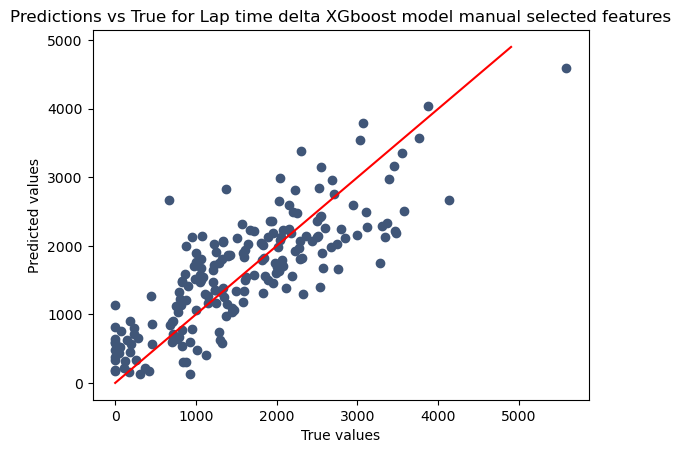

In [63]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

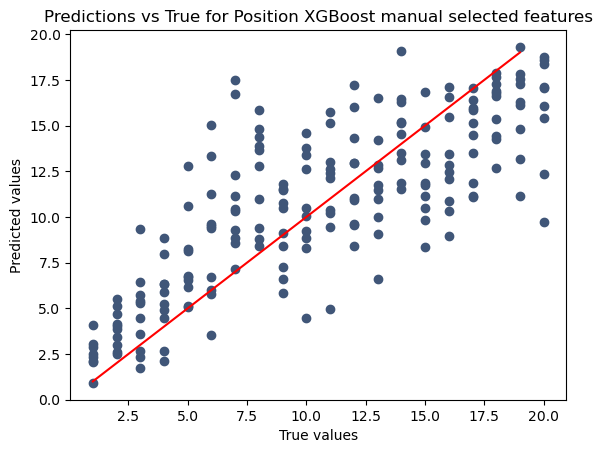

In [64]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

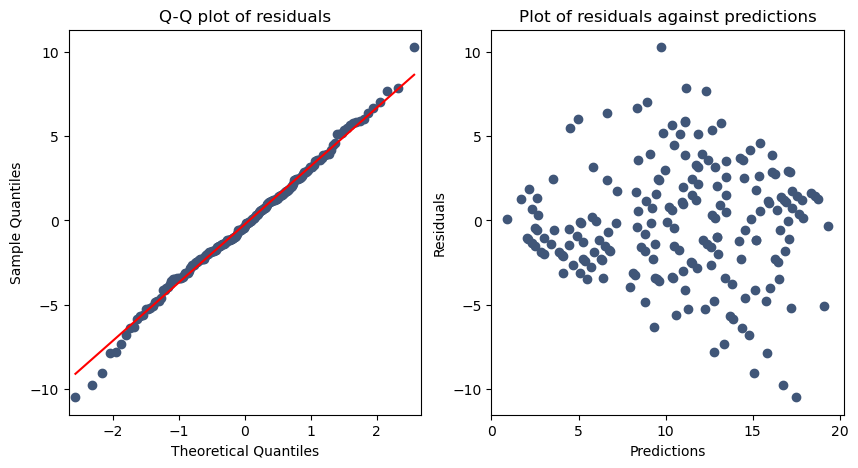

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9956023097038269, pvalue=0.8435552716255188)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


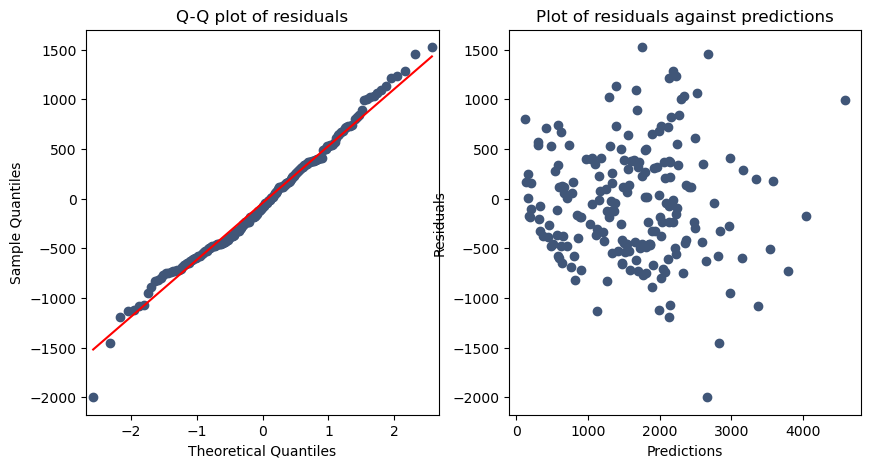

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9895597696304321, pvalue=0.16402079164981842)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [65]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

In [66]:
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'yes'},index=[0]))

## Optimised XGboost for laptime delta

In [90]:
fold=5
print(f' validation size is {X_train_manual.shape[0]/fold}')
print(f'Train size is {X_train_manual.shape[0] - X_train_manual.shape[0]/fold} ')

 validation size is 339.8
Train size is 1359.2 


In [92]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    
    }
   
]

grid_xgb = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=200,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb = grid_xgb.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'xgboost__n_estimators': 90, 'xgboost__max_depth': 9, 'xgboost__learning_rate': 0.1}


In [93]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,150,10),
    'xgboost__learning_rate':[0.1],
    'xgboost__max_depth':np.arange(5,10,1),

    
    }
   
]

grid_xgb_lap = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_lap = grid_xgb_lap.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb_lap.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 90}


In [94]:
results_xgb_delta = pd.DataFrame({'Validation score':fittedgrid_xgb_lap.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_lap.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_lap.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.404068,0.928455,50,0.1,5
1,0.419052,0.942245,60,0.1,5
2,0.431220,0.950940,70,0.1,5
3,0.436578,0.957632,80,0.1,5
4,0.441234,0.963560,90,0.1,5


In [95]:
# Save the best model
joblib.dump(fittedgrid_xgb_lap.best_estimator_, 'pickled_best_XGboost_regression_model_lap_delta.pkl')

['pickled_best_XGboost_regression_model_lap_delta.pkl']

In [96]:
XG_best_lapdelta_model = joblib.load('pickled_best_XGboost_regression_model_lap_delta.pkl')

In [97]:
delta_predictions=XG_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6925263569126382
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 306308.3829948567
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 439.39621713210124


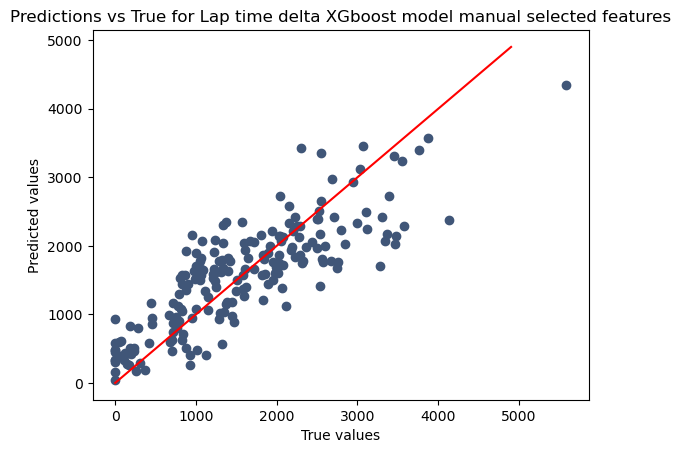

In [98]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

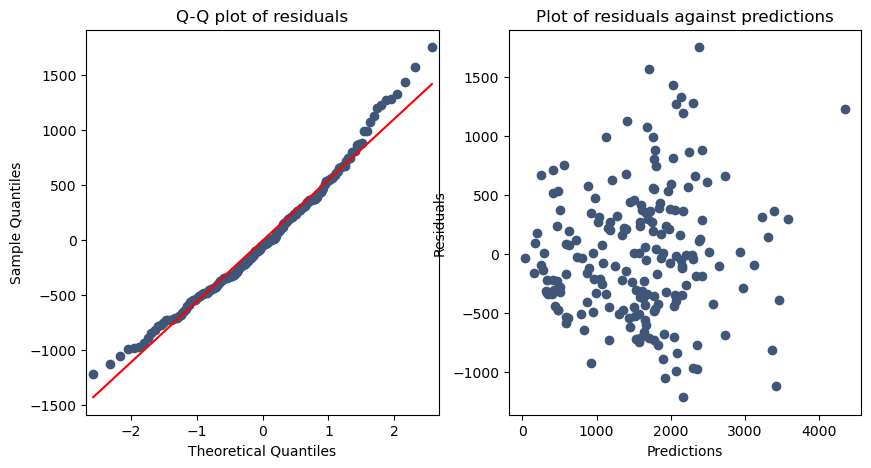

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9814015626907349, pvalue=0.010576349683105946)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [99]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [100]:
Results_summary.append(pd.DataFrame({'Model':'Optimised XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

## Optimise XGBoost for position

In [101]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    }
   
]

grid_xgb_pos = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=200,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'xgboost__n_estimators': 180, 'xgboost__max_depth': 3, 'xgboost__learning_rate': 0.1}


In [102]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(100,200,10),
    'xgboost__learning_rate':[0.1],
    'xgboost__max_depth':np.arange(1,6,1),

    
    }
   
]

grid_xgb_pos = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 180}


In [103]:
results_xgb_pos = pd.DataFrame({'Validation score':fittedgrid_xgb_pos.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_pos.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_pos.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.404068,0.928455,50,0.1,5
1,0.419052,0.942245,60,0.1,5
2,0.431220,0.950940,70,0.1,5
3,0.436578,0.957632,80,0.1,5
4,0.441234,0.963560,90,0.1,5


In [104]:
# Save the best model
joblib.dump(fittedgrid_xgb_pos.best_estimator_, 'pickled_best_XGboost_regression_model_position.pkl')

['pickled_best_XGboost_regression_model_position.pkl']

In [105]:
XG_best_position_model = joblib.load('pickled_best_XGboost_regression_model_position.pkl')

In [106]:
pos_predictions=XG_best_position_model.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6398723396822839
Position XGBoost regression Initial MSE score with manual selected feaure 11.58838426651946
Position XGBoost regression Initial MAE score with manual selected feaure 2.7883043696685714


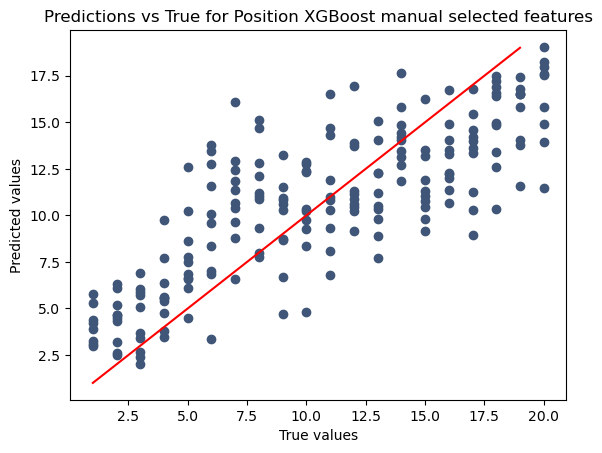

In [107]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

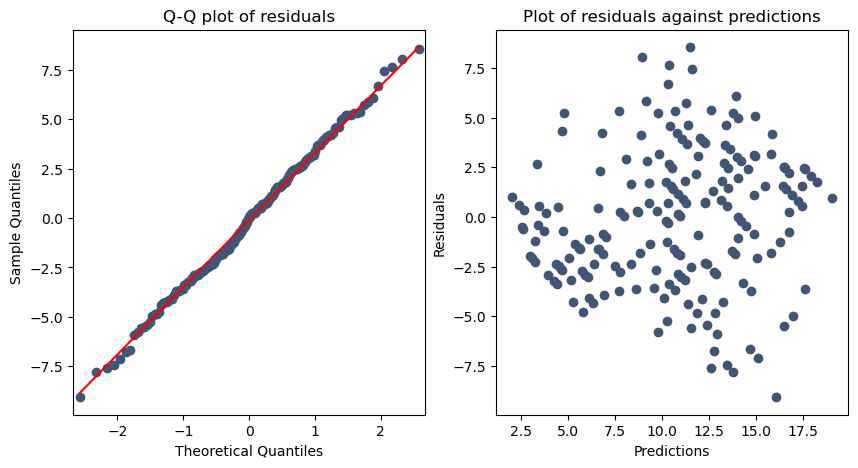

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9958711266517639, pvalue=0.8757799863815308)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [108]:
#residuals
pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)


In [109]:
Results_summary.append(pd.DataFrame({'Model':'Optmised XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))


## Simple Neural Network

In [68]:
X_train_manual_split, X_val_manual, ydelta_train_split, ydelta_val = train_test_split(X_train_manual,ydelta_train,test_size=0.2,random_state=123)

In [69]:
def create_model():
    # Create a new sequential model
    model = keras.Sequential()

    regularizer = keras.regularizers.l2(0.01)

    # Declare the hidden layers
    
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation="relu", kernel_regularizer=regularizer))
    
    # Declare the output layer
    model.add(Dense(1)) # For regression, we don't specify any activation function.

    # Compile the model
    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(),  
        # Loss function to minimize
        loss=keras.losses.MeanAbsoluteError()
    )
    return model

In [81]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.05, patience=10)
clf = KerasRegressor(build_fn=create_model,epochs=400, verbose=0,callbacks=[callbacks])

In [84]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

nueral_network_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('nueral_network',clf)# classifier
        
]
nn_pipe=Pipeline(nueral_network_estimator)

In [72]:
X_train_manual_split_array=nn_pipe['column_transform'].fit_transform(X_train_manual_split)
X_val_manual_array=nn_pipe['column_transform'].transform(X_val_manual)

In [73]:
history=nn_pipe['nueral_network'].fit(X_train_manual_split_array,ydelta_train_split.values, validation_data=(X_val_manual_array,ydelta_val.values))

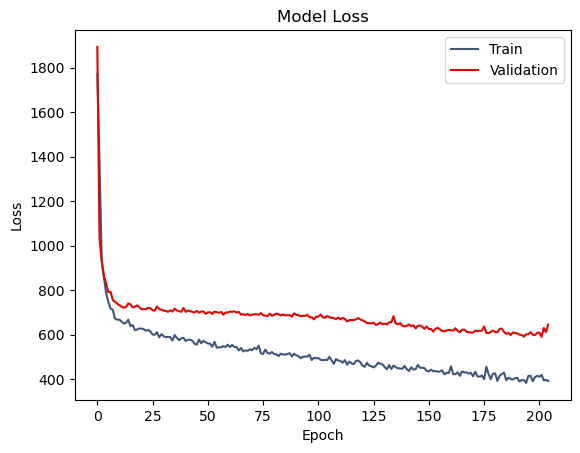

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [75]:
history = nn_pipe.fit(X_train_manual,ydelta_train)

In [76]:
delta_predictions=history.predict(X_test_manual)
print(f'Lap Delta Neural Network regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Neural Network regression Initial R2 score with manual selected featuers 0.6417116124674791
Lap Delta Neural Network regression Initial MSE score with manual selected feaure 356930.5503032627
Lap Delta Neural Network regression Initial MAE score with manual selected feaure 451.6957316495934


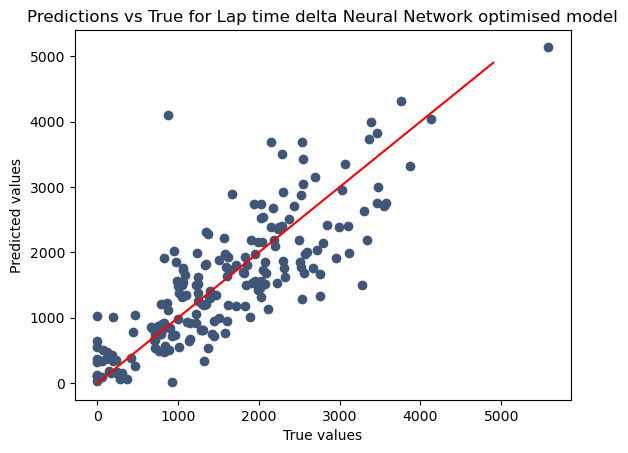

In [77]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Neural Network optimised model')
plt.show()

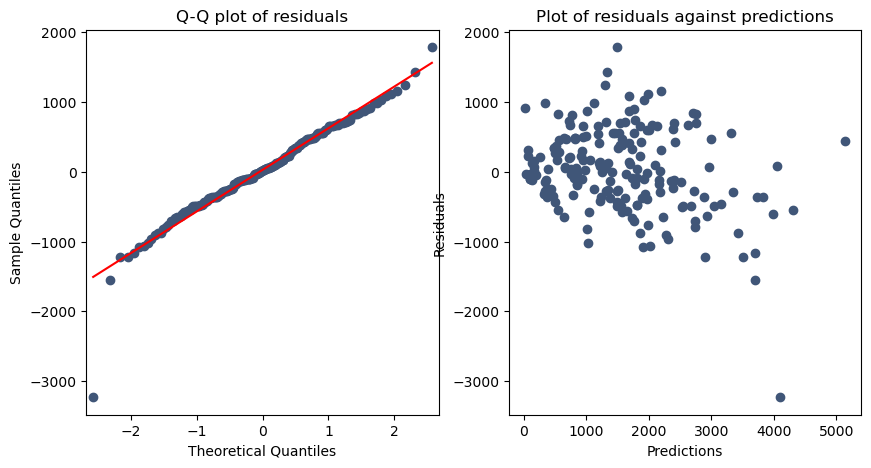

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9612656831741333, pvalue=3.282343823229894e-05)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [78]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [79]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

### Neural Network Position

In [82]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.05, patience=10)
clf = KerasRegressor(build_fn=create_model,epochs=400, verbose=0,callbacks=[callbacks])

In [ ]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

nueral_network_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('nueral_network',clf)# classifier
        
]
nn_pipe=Pipeline(nueral_network_estimator)

In [85]:
history = nn_pipe.fit(X_train_manual,ypos_train)
pos_predictions=history.predict(X_test_manual)
print(f'Position Neural Network regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Neural Network regression Initial R2 score with manual selected featuers 0.6200443982924703
Position Neural Network regression Initial MSE score with manual selected feaure 12.22641857867552
Position Neural Network regression Initial MAE score with manual selected feaure 2.7221221279124825


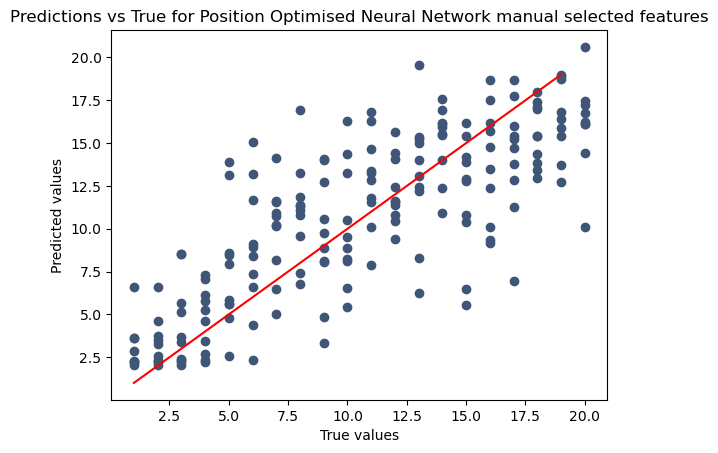

In [86]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Neural Network manual selected features')
plt.show()

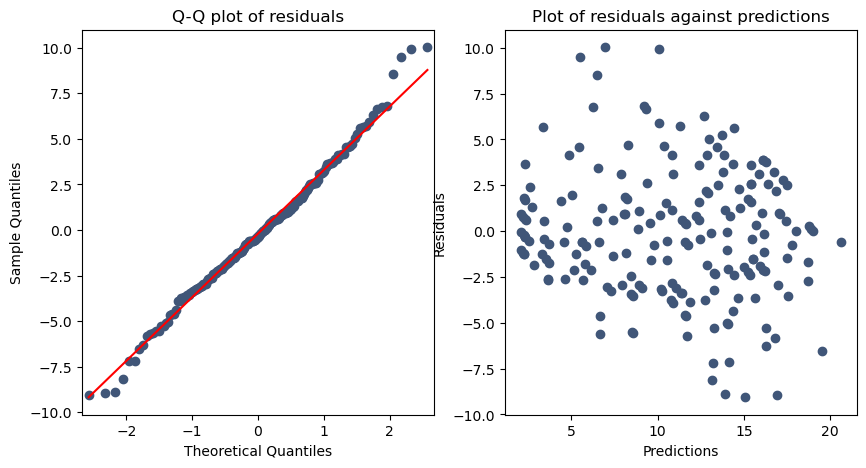

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.991827666759491, pvalue=0.33902326226234436)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [88]:

pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)

In [89]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))

# Summary

In [143]:
Regression_model_summary = pd.concat(Results_summary)

In [144]:
Regression_model_summary.reset_index(drop=True,inplace=True)

In [157]:
Position_summary = Regression_model_summary[Regression_model_summary['Target'] == 'Position']
Lapdelta_summary = Regression_model_summary[Regression_model_summary['Target'] == 'LapDelta']

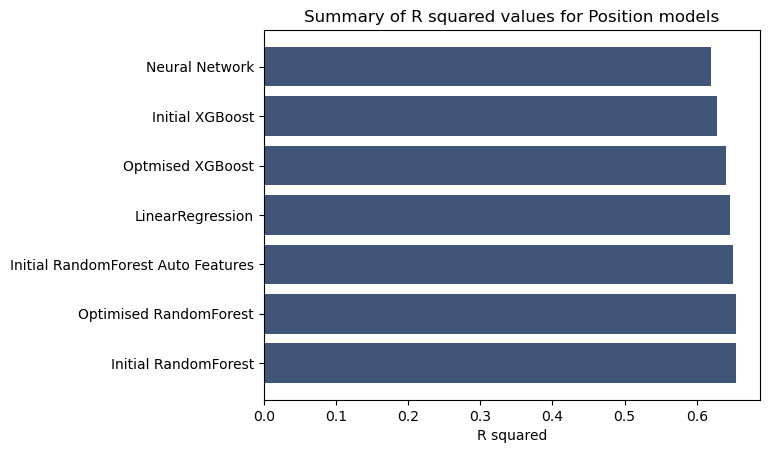

In [146]:
Position_summary.sort_values(by='R2',ascending=False,inplace=True)
plt.barh(Position_summary['Model'],Position_summary['R2'])
plt.title('Summary of R squared values for Position models')
plt.xlabel('R squared')
plt.show()


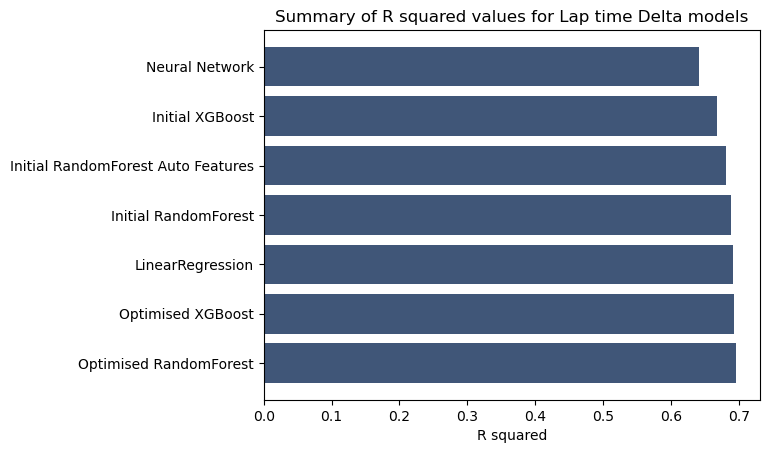

In [153]:
Lapdelta_summary.sort_values(by='R2',ascending=False,inplace=True)
plt.barh(Lapdelta_summary['Model'],Lapdelta_summary['R2'])

plt.title('Summary of R squared values for Lap time Delta models')
plt.xlabel('R squared')
plt.show()

In [158]:
Regression_model_summary

,Model,Target,R2,MSE,MAE,homoscedasticity
0,LinearRegression,Position,0.646671,11.369617,2.656429,yes
1,LinearRegression,LapDelta,0.691183,307647.136688,438.213010,no
2,Initial RandomForest,Position,0.654465,11.118822,2.645663,yes
3,Initial RandomForest,LapDelta,0.689061,309760.910164,433.312959,yes
4,Initial RandomForest Auto Features,Position,0.649656,11.273561,2.676837,yes
5,Initial RandomForest Auto Features,LapDelta,0.681322,317470.442101,441.067041,no
6,Initial XGBoost,Position,0.628149,11.965628,2.712540,yes
7,Initial XGBoost,LapDelta,0.667720,331020.788280,465.401873,yes
8,Neural Network,LapDelta,0.641712,356930.550303,451.695732,no
9,Neural Network,Position,0.620044,12.226419,2.722122,yes


In [159]:
Regression_model_summary.to_pickle('./data/model_data/regression_model_summary.pkl',compression='gzip')